# EDA of "Capybaras" Capstone project
## Animal species image recognition in Côte d'Ivoire's Jungle


In [6]:
#import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from collections import defaultdict

## Data analysis

In [7]:
data_folder = 'data' # ! if this notebook and folders "train_features" and "test_features" are in the same folder use '.'

First we can visually inspect the photos of the folders "train_features" and "test_features". There are photos shot with automatical camera in jungle. There are animals on some pictures. From the challenge description, that are always only one species on the picture, otherwise no species. Pictures are in different sizes and some picture are RGB, others are black/white.

In [19]:
# Load the CSV data into a pandas DataFrame

#Lets take  a look at the both train and test data
train_features = pd.read_csv(os.path.join(data_folder,'train_features.csv'),index_col='id')
train_features['filepath'] = data_folder+'/'+train_features.filepath
train_features.head()

,filepath,site
id,,
ZJ000000,data/train_features/ZJ000000.jpg,S0120
ZJ000001,data/train_features/ZJ000001.jpg,S0069
ZJ000002,data/train_features/ZJ000002.jpg,S0009
ZJ000003,data/train_features/ZJ000003.jpg,S0008
ZJ000004,data/train_features/ZJ000004.jpg,S0036


In [20]:
#Lets alsko take a look at the test data
test_features = pd.read_csv(os.path.join(data_folder,'test_features.csv'),index_col='id')
test_features['filepath'] = data_folder+'/'+test_features.filepath
#test_df.info()
test_features.head()

,filepath,site
id,,
ZJ016488,data/test_features/ZJ016488.jpg,S0082
ZJ016489,data/test_features/ZJ016489.jpg,S0040
ZJ016490,data/test_features/ZJ016490.jpg,S0040
ZJ016491,data/test_features/ZJ016491.jpg,S0041
ZJ016492,data/test_features/ZJ016492.jpg,S0040


In [21]:
#Lets also take a look at the train labels
train_labels = pd.read_csv(os.path.join(data_folder,'train_labels.csv'),index_col='id')
train_labels.head()


,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Let's store a sorted list of the labels, so that we can sort the inputs and outputs to our model in a consistent way.

In [22]:
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

We can see, that train/test_features.csv do have photos IDs, filepath of the photos and site where they were shot on.

"train_labels.csv" do have photo IDs and 8 another different column for each species (0 or 1).

## Sites

Let's see how many sites are in the train and test dataset

In [23]:
# Group by the 'site' column and count the number of images for each site
train_site_counts = train_features['site'].value_counts()
test_site_counts = test_features['site'].value_counts()
print(f"Number of sites: train - {len(train_site_counts)}, test - {len(test_site_counts)}")

Number of sites: train - 148, test - 51


We can see below that we don't have the same sites for train and test datasets. So that we can't use sites for our model

In [24]:
common_sites = set(train_features['site']).intersection(set(test_features['site']))
common_sites

set()

`common_sites` is an empty set so there is no overlap between train and test sites

## Color channels

Now we can explore if pictures in train_features are RGB, Black/White or overexposed(almost white).

In [25]:
# Initialize counters for each category
counts = {
    'RGB': 0,
    'Black/White': 0,
    'Overexposed (White) in RGB': 0,
    'Overexposed (White) in Grayscale': 0,
    'Other': 0
}

# Define a function to check the mode of the image and update counts
def check_image_mode(file_path):
    try:
        with Image.open(file_path) as img:
            mode = img.mode
            if mode == 'RGB':
                result = check_rgb_image(img)
            elif mode in ['L', '1']:
                result = check_grayscale_image(img)
            else:
                result = 'Other'
            update_counts(result)
            return result
    except Exception as e:
        update_counts(f'Error: {e}')
        return f'Error: {e}'

# Define a function to check if an RGB image is overexposed
def check_rgb_image(img):
    img_array = np.array(img)
    white_pixel_threshold = 245  # Threshold for what is considered "almost white"
    white_pixels = np.sum(np.all(img_array >= white_pixel_threshold, axis=-1))
    total_pixels = img_array.shape[0] * img_array.shape[1]
    
    white_percentage = (white_pixels / total_pixels) * 100

    if white_percentage > 90:
        return 'Overexposed (White) in RGB'
    else:
        return 'RGB'

# Define a function to check if a grayscale image is overexposed
def check_grayscale_image(img):
    img_array = np.array(img)
    white_pixel_threshold = 245  # Threshold for what is considered "almost white"
    white_pixels = np.sum(img_array >= white_pixel_threshold)
    total_pixels = img_array.size
    
    white_percentage = (white_pixels / total_pixels) * 100

    if white_percentage > 90:
        return 'Overexposed (White) in Grayscale'
    else:
        return 'Black/White'

# Define a function to update counts
def update_counts(result):
    if result in counts:
        counts[result] += 1
    else:
        counts['Other'] += 1

# Check each image and print its type
for file_path in train_features.filepath:
    result = check_image_mode(file_path)
    # print(f'{file_path}: {result}')




Counts:
RGB: 14268 (86.54%)
Black/White: 2193 (13.30%)
Overexposed (White) in RGB: 23 (0.14%)
Overexposed (White) in Grayscale: 4 (0.02%)
Other: 0 (0.00%)


<Figure size 1200x800 with 0 Axes>

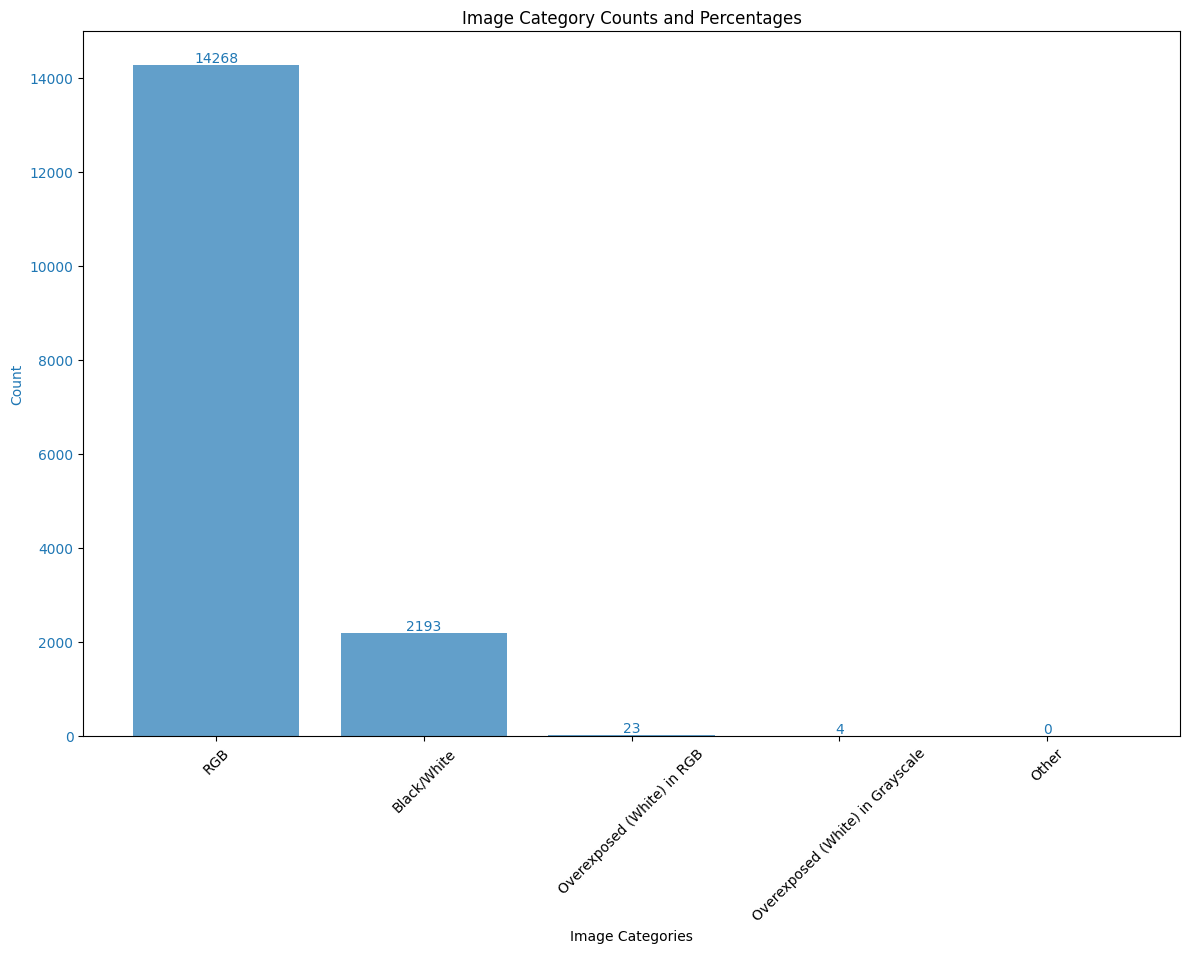

In [26]:
# Print counts for each category
print("\nCounts:")
total_images = sum(counts.values())
percentages = {category: (count / total_images) * 100 for category, count in counts.items()}
for category, count in counts.items():
    print(f'{category}: {count} ({percentages[category]:.2f}%)')

# Plot the results
categories = list(counts.keys())
values = list(counts.values())
percentages_values = list(percentages.values())

plt.figure(figsize=(12, 8))

# Create a bar chart with both counts and percentages
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot counts
color = 'tab:blue'
ax1.set_xlabel('Image Categories')
ax1.set_ylabel('Count', color=color)
bars = ax1.bar(categories, values, color=color, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2.0, height,
             f'{height}', ha='center', va='bottom', color=color)

# Add title and show the plot
plt.title('Image Category Counts and Percentages')
fig.tight_layout()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.savefig('image_category_counts_with_percentages.png')
plt.show()

As we can see most of the pictures (84.10%) are RGB.

## Size

After visual inspection we recognised, that pictures are also different sizes. Let's see

In [27]:
# Initialize a dictionary to count images by their dimensions
size_counts = defaultdict(int)

# Define a function to get the size of the image and update counts
def get_image_size(file_path):
    try:
        with Image.open(file_path) as img:
            size = img.size
            size_counts[size] += 1
            return size
    except Exception as e:
        print(f'Error processing {file_path}: {e}')
        return None

# Process each image to count sizes
for file_path in train_features.filepath:
    size = get_image_size(file_path)

# Sort sizes by count from highest to lowest
sorted_sizes = sorted(size_counts.items(), key=lambda x: x[1], reverse=True)

# Unpack sorted sizes and counts
sizes, counts = zip(*sorted_sizes)
percentages = [(count / sum(counts)) * 100 for count in counts]


Size Counts:
(640, 360): 7490 (45.43%)
(960, 540): 6345 (38.48%)
(640, 335): 970 (5.88%)
(360, 240): 864 (5.24%)
(960, 515): 458 (2.78%)
(160, 120): 293 (1.78%)
(360, 215): 67 (0.41%)
(160, 95): 1 (0.01%)


<Figure size 1200x800 with 0 Axes>

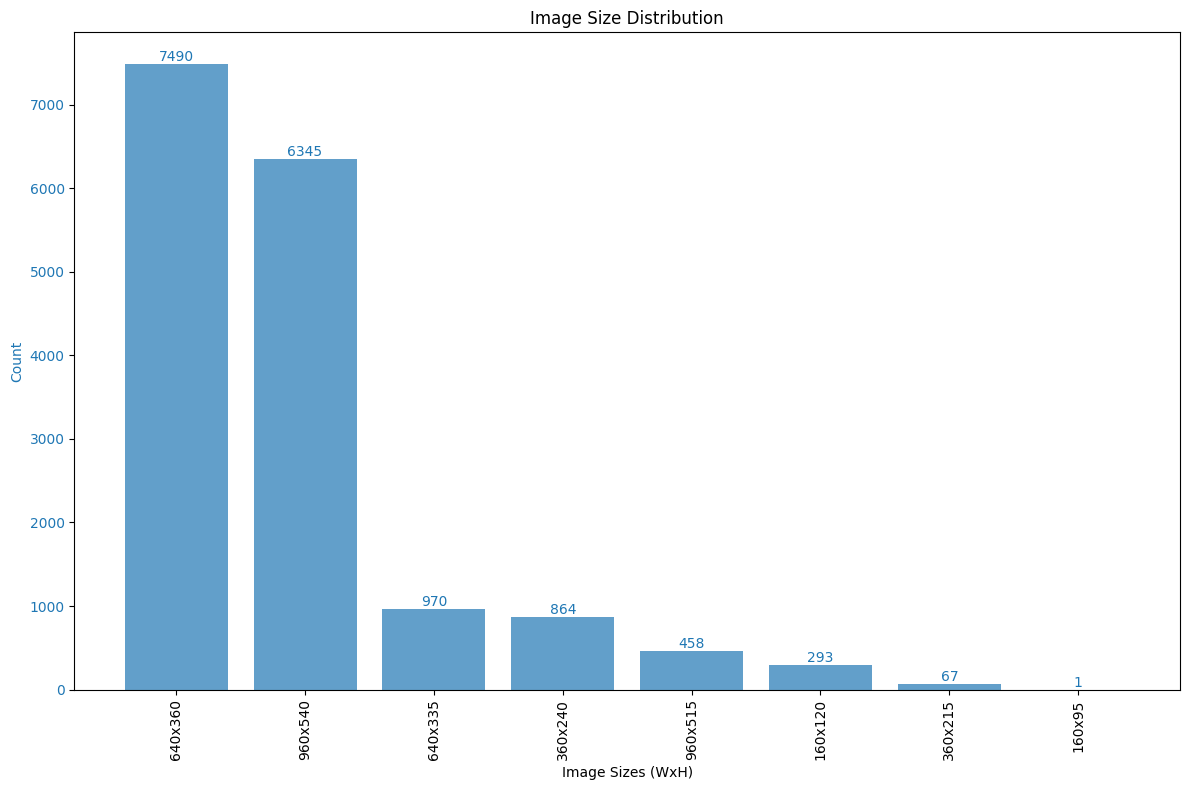

In [28]:
# Print counts and percentages for each size
print("\nSize Counts:")
for size, count in zip(sizes, counts):
    print(f'{size}: {count} ({percentages[sizes.index(size)]:.2f}%)')

# Plot the results
sizes_labels = [f'{w}x{h}' for (w, h) in sizes]

plt.figure(figsize=(12, 8))

# Create a bar chart with counts for image sizes
fig, ax = plt.subplots(figsize=(12, 8))

# Plot counts
color = 'tab:blue'
ax.set_xlabel('Image Sizes (WxH)')
ax.set_ylabel('Count', color=color)
bars = ax.bar(sizes_labels, counts, color=color, alpha=0.7)
ax.tick_params(axis='y', labelcolor=color)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height,
            f'{height}', ha='center', va='bottom', color=color)

# Add title and show the plot
plt.title('Image Size Distribution')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
fig.tight_layout()
plt.savefig('image_size_distribution_sorted.png')


As we can see the most of pictures are 640x360.

## Explore the data

Now let's see what some of the actual images look like. The code below iterates through a list of species and selects a single random image from each species to display, along with its image ID and label. You can try changing the `random_state` variable to display a new set of images.

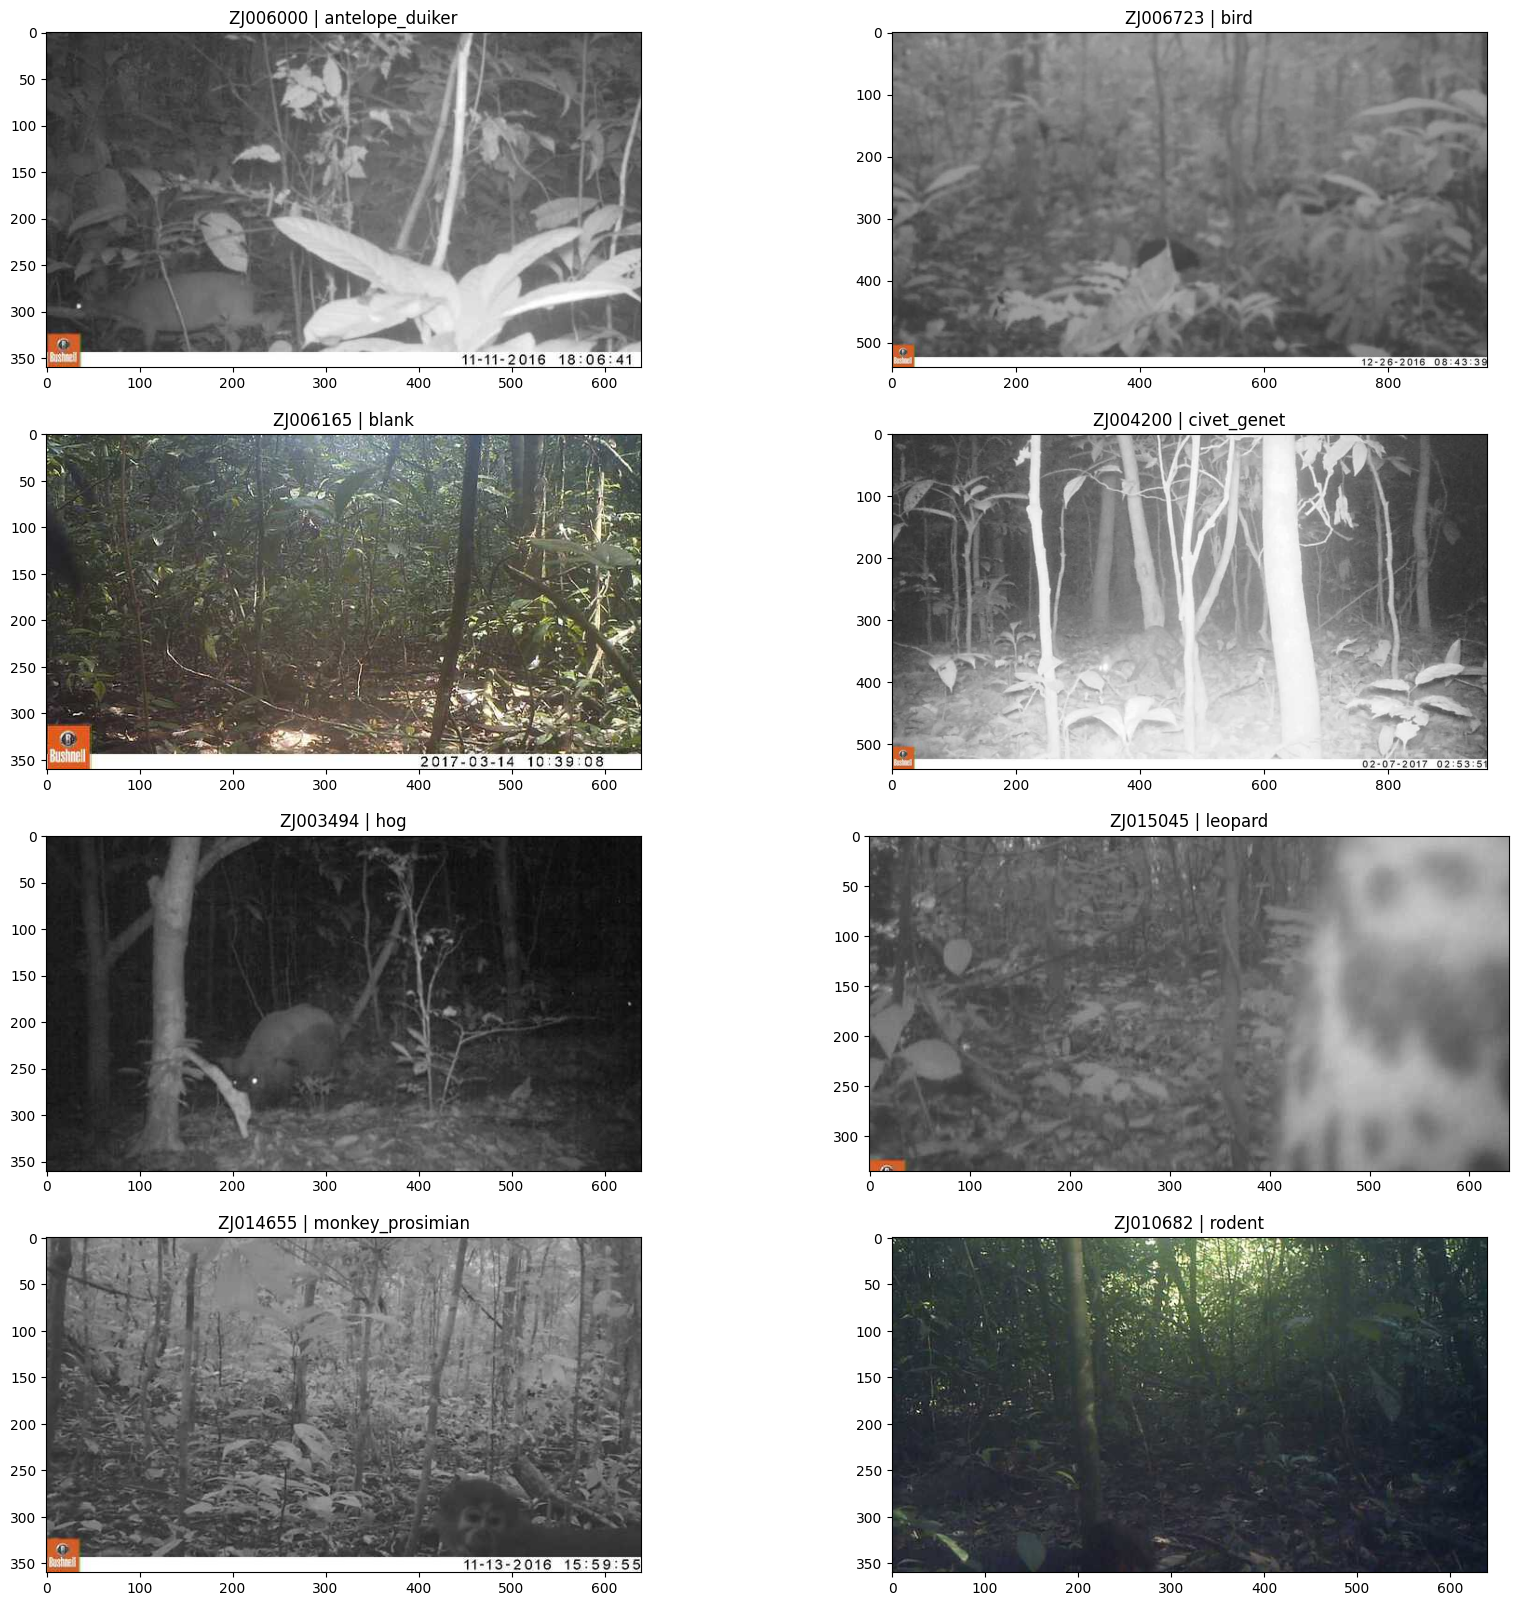

In [29]:
# we'll create a grid with 8 positions, one for each label (7 species, plus blanks)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# iterate through each species
for species, ax in zip(species_labels, axes.flat):
    # get an image ID for this species
    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=42)
        .index[0]
    )
    # reads the filepath and returns a numpy array
    img = mpimg.imread(train_features.loc[img_id].filepath)
    # plot etc
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{img_id} | {species}")

We can see a lot of photos with orange logo and white timestamp below

Don't be too worried, if you cannot spot animals in some pictures. The combination of low-quality images and animals blending in well with their surroundings can make it tough to spot some animals.

## Distribution

Let's look at the distribution of species across the training set:

Absolute values:

In [30]:
train_labels.sum().sort_values(ascending=False)

monkey_prosimian    2492.0
antelope_duiker     2474.0
civet_genet         2423.0
leopard             2254.0
blank               2213.0
rodent              2013.0
bird                1641.0
hog                  978.0
dtype: float64

Percentage values:

In [31]:
train_labels.sum().divide(train_labels.shape[0]).sort_values(ascending=False)*100

monkey_prosimian    15.114022
antelope_duiker     15.004852
civet_genet         14.695536
leopard             13.670548
blank               13.421883
rodent              12.208879
bird                 9.952693
hog                  5.931587
dtype: float64